In [ ]:
import matplotlib.pyplot as plt
import numpy as np

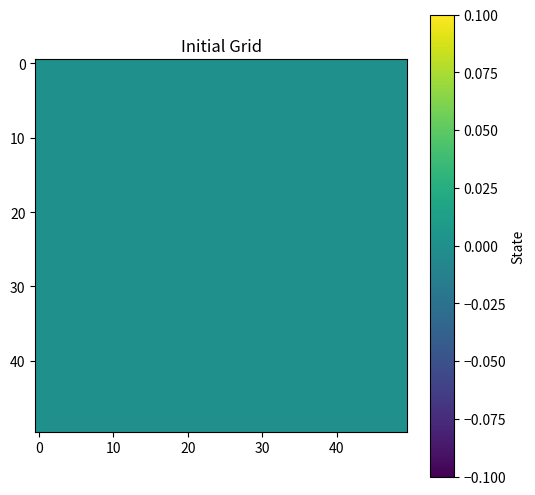

In [ ]:
# Define the grid size and the states
grid_size = 50
states = {'V': 0, 'H': 1, 'I': 2, 'C': 3}  # V: vacant, H: housing, I: industrial, C: commercial

# Initialize the grid with vacant cells
grid = np.full((grid_size, grid_size), states['V'])

# Display the initial grid
plt.figure(figsize=(6, 6))
plt.imshow(grid, cmap='viridis')
plt.colorbar(label='State')
plt.title('Initial Grid')
plt.show()

In [ ]:
# Define the exogenous growth rates for each urban function
growth_rates = {'H': 0.02, 'I': 0.03, 'C': 0.04}  # H: housing, I: industrial, C: commercial

# Define the initial number of cells to be converted
initial_cells = {'H': 10, 'I': 5, 'C': 5}  # H: housing, I: industrial, C: commercial

# Define the number of iterations for the simulation
iterations = 100

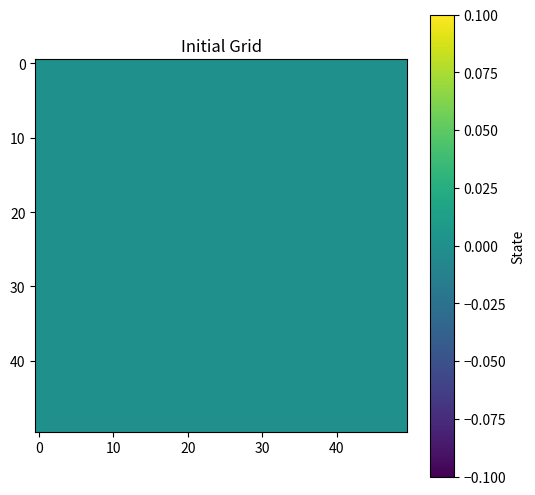

In [ ]:
# Step 1: Define the grid and the states

# Define the grid size and the states
grid_size = 50
states = {'V': 0, 'H': 1, 'I': 2, 'C': 3}  # V: vacant, H: housing, I: industrial, C: commercial

# Initialize the grid with vacant cells
grid = np.full((grid_size, grid_size), states['V'])

# Display the initial grid
plt.figure(figsize=(6, 6))
plt.imshow(grid, cmap='viridis')
plt.colorbar(label='State')
plt.title('Initial Grid')
plt.show()

In [ ]:
# Step 2: Define the exogenous growth rates and the initial number of cells to be converted

# Define the exogenous growth rates for each urban function
growth_rates = {'H': 0.02, 'I': 0.03, 'C': 0.04}  # H: housing, I: industrial, C: commercial

# Define the initial number of cells to be converted
initial_cells = {'H': 10, 'I': 5, 'C': 5}  # H: housing, I: industrial, C: commercial

# Initialize a dictionary to store the number of cells to be converted for each state in the previous iteration
previous_cells = initial_cells.copy()

# Function to calculate the net number of cells to be converted at each iteration
def calculate_cells_to_convert(iteration):
    cells_to_convert = {}
    for state in ['H', 'I', 'C']:
        if iteration == 0:
            # At the first iteration, use the initial number of cells to be converted
            cells_to_convert[state] = initial_cells[state]
        else:
            # In subsequent iterations, apply the growth rate to the number of cells converted in the previous iteration
            cells_to_convert[state] = int(previous_cells[state] * (1 + growth_rates[state]))
            # Update the number of cells to be converted for the current state in the previous iteration
            previous_cells[state] = cells_to_convert[state]
    return cells_to_convert

# Test the function
print('Cells to convert at iteration 0:', calculate_cells_to_convert(0))
print('Cells to convert at iteration 1:', calculate_cells_to_convert(1))

Cells to convert at iteration 0: {'H': 10, 'I': 5, 'C': 5}
Cells to convert at iteration 1: {'H': 10, 'I': 5, 'C': 5}


In [ ]:
# Step 3: Define the neighbourhood of a cell and calculate the transition potentials

# Define the radius of the neighbourhood
radius = 6

# Function to get the neighbourhood of a cell
def get_neighbourhood(grid, row, col):
    # Define the range of the neighbourhood
    row_range = range(max(0, row - radius), min(grid_size, row + radius + 1))
    col_range = range(max(0, col - radius), min(grid_size, col + radius + 1))
    # Get the square neighbourhood
    square_neighbourhood = grid[np.ix_(row_range, col_range)]
    # Create a mask for the circular neighbourhood
    circle_mask = np.zeros_like(square_neighbourhood, dtype=bool)
    center = radius, radius  # The center of the circle is the cell itself
    for i in range(square_neighbourhood.shape[0]):
        for j in range(square_neighbourhood.shape[1]):
            # If the Euclidean distance from the center to the cell is less than or equal to the radius, include the cell in the circle
            if np.sqrt((center[0] - i) ** 2 + (center[1] - j) ** 2) <= radius:
                circle_mask[i, j] = True
    # Return the circular neighbourhood
    return square_neighbourhood[circle_mask]

# Test the function
print('Neighbourhood of the cell at (25, 25):\n', get_neighbourhood(grid, 25, 25))
print('The number of Neighborss of the cell at the center is ', len(get_neighbourhood(grid, 25, 25)))

Neighbourhood of the cell at (25, 25):
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
The number of Neighborss of the cell at the center is  113


In [ ]:
import numpy as np

# Define the weighting parameters m_kd for transitions from state i to state j
# These parameters are specified in Table 1
m_kd = {
    'V->C': [25, 25, 25, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    'V->I': [3, 3, 2, 1, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
    'V->H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
    'H->I': [-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'H->C': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'I->C': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}

# Function to calculate the transition potential for a cell
def calculate_transition_potential(grid, row, col):
    # Get the neighbourhood of the cell
    neighbourhood = get_neighbourhood(grid, row, col)
    # Calculate the transition potential for each possible transition
    transition_potentials = {}
    for transition, weights in m_kd.items():
        # Calculate the weighted sum for the transition
        weighted_sum = sum(weight * (neighbourhood == state) for weight, state in zip(weights, range(4)))
        # Calculate the stochastic disturbance term
        R = np.random.uniform(0, 1)
        alpha = 1  # This parameter allows control of the size of the stochastic perturbation
        S = 1 + (-np.log(R)) ** alpha
        # Calculate the transition potential
        P_ij = S * (1 + weighted_sum)
        transition_potentials[transition] = P_ij
    return transition_potentials

# Test the function
# print('Transition potentials for the cell at (25, 25):', calculate_transition_potential(grid, 25, 25))

# Initialize a dictionary to hold the transition potentials for all cells
transition_potentials_all_cells = {}

# Iterate over all cells in the grid
for row in range(grid.shape[0]):
    for col in range(grid.shape[1]):
        # Calculate the transition potential for the current cell
        transition_potentials = calculate_transition_potential(grid, row, col)
        # Store the transition potentials in the dictionary
        transition_potentials_all_cells[(row, col)] = transition_potentials
        print('Transition potentials for the cell at ({}, {}):'.format(row, col),           transition_potentials)

NameError: name 'grid' is not defined